# HEROS: Demonstration Notebook
This notebook is set up as a demonstration for running HEROS.

***
## Imports:

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from skrebate import MultiSURF, TURF # Install using: pip install skrebate==0.7
from sklearn.metrics import classification_report, balanced_accuracy_score

## If pip installed:
#from skheros.heros import HEROS
## If locally run:
from src.skheros.heros import HEROS

current_working_directory = os.getcwd()
print(current_working_directory)

c:\Users\ryanu\Documents\GitHub\heros


***
## Set Up Local Run Parameters


In [2]:
local_save = True
folder_path = './output'
if not os.path.exists(folder_path):
        os.makedirs(folder_path)
if local_save:
    output_path = './output'
else:
    output_path = folder_path

full_run = True

***
## Data

### Load Training/Testing Dataset Example (6-bit Multiplexer)
6-bit Multiplexer dataset includes only 64 unique instances and 6 features (all predictive), with A_0 and A_1 being important to predict every instance and R_0, R_1, R_2, and R_3; each predictive in only 1/4 of the 64 instances. All features and outcome (i.e. 'class') are binary-valued. This small, simpler dataset is still challenging in that it involves finding both 3-way feature interactions and a heterogenous pattern of association to solve. This data includes no missing values, and all features are treated as categorical since they are binary (however they could also be treated as quantitative).

In [3]:
## Load Training and Testing Datasets
train_data = 'evaluation/datasets/partitioned/multiplexer/A_multiplexer_6_bit_500_inst_CV_Train_1.txt'
test_data = 'evaluation/datasets/partitioned/multiplexer/A_multiplexer_6_bit_500_inst_CV_Test_1.txt'

## Other Example Dataset Pairs
#train_data = 'evaluation/datasets/partitioned/multiplexer/B_multiplexer_11_bit_5000_inst_CV_Train_1.txt'
#test_data = 'evaluation/datasets/partitioned/multiplexer/B_multiplexer_11_bit_5000_inst_CV_Test_1.txt'

#train_data = 'evaluation/datasets/partitioned/multiplexer/C_multiplexer_20_bit_10000_inst_CV_Train_1.txt'
#test_data = 'evaluation/datasets/partitioned/multiplexer/C_multiplexer_20_bit_10000_inst_CV_Test_1.txt'

#train_data = 'evaluation/datasets/partitioned/gametes/A_uni_4add_CV_Train_1.txt'
#test_data = 'evaluation/datasets/partitioned/gametes/A_uni_4add_CV_Test_1.txt'

#train_data = 'evaluation/datasets/partitioned/gametes/C_2way_epistasis_CV_Train_1.txt'
#test_data = 'evaluation/datasets/partitioned/gametes/C_2way_epistasis_CV_Test_1.txt'

#train_data = 'evaluation/datasets/partitioned/gametes/E_uni_4het_CV_Train_1.txt'
#test_data = 'evaluation/datasets/partitioned/gametes/E_uni_4het_CV_Test_1.txt'

train_df = pd.read_csv(train_data, sep="\t")
print(train_df.head())
test_df = pd.read_csv(test_data, sep="\t")
print(test_df.head())

   A_0  A_1  R_0  R_1  R_2  R_3  Class  Group  InstanceID
0    1    0    1    0    1    1      1      2           1
1    1    0    0    0    0    1      0      2           2
2    0    1    1    0    0    1      0      1           3
3    1    1    1    1    1    1      1      3           4
4    0    0    0    1    1    0      0      0           5
   A_0  A_1  R_0  R_1  R_2  R_3  Class  Group  InstanceID
0    0    0    0    1    0    0      0      0           8
1    1    0    0    1    1    0      1      2          14
2    0    0    1    1    1    1      1      0          29
3    1    1    0    0    1    0      0      3          44
4    0    0    1    1    0    0      1      0          58


In [4]:
# Create unique output folder for specific target dataset
file_name = os.path.splitext(os.path.basename(train_data))[0]
output_path = output_path+'/'+file_name
if not os.path.exists(output_path):
        os.makedirs(output_path)

### Prepare Dataset for Analysis
Data used for training HEROS has the following requirements:
1. The training data must be passed as separate array-like objects including:
    1. 'X' {n_samples, n_features} Training instance features.
    3. 'y' {n_samples} Training labels of the outcome variable.
3. 'y must always be provided and must not include any missing values.
4. Missing values are allowed in 'X' but data instances should be excluded that have missing values for all features. Note, HEROS treats missing values as missing, i.e. no imputation of values are made or needed. Any rule that specifies a given feature will not match an instance with a missing value at that instance. 

For this demo, the 6-bit multiplexer data requires minimal preparation, i.e. only breaking the loaded dataset into separate array-like objects, and removing additional columns. 'ek' scores are provided for this dataset which were calculated outside of this notebook by running the MultiSURF (feature importance estimation) algorithm on this same dataset. For MultiSURF, see our scikit-rebate respository at https://github.com/UrbsLab/scikit-rebate. 

In [5]:
# Identify dataset column names of importance
outcome_label = 'Class'
instanceID_label = 'InstanceID' #None for datasets without an instance ID column
excluded_column = 'Group' #'Group' for multiplexer datasets, 'Model' for heterogeneous GAMETES datasets - Column in sample data used only for internal analysis

#Prepare Training Data
try:
    X = train_df.drop(excluded_column, axis=1) #Remove excluded column from consideration in this notebook
except:
    X = train_df
    print('Excluded column not available')
try:
    X = X.drop(instanceID_label,axis=1)
except:
    print('Instance ID coulmn not available')

X = X.drop(outcome_label, axis=1)
feature_names = X.columns # 6-bit multiplexer feature names are ['A_0','A_1','R_0', 'R_1', 'R_2','R_3']
cat_feat_indexes = list(range(X.shape[1])) #all feature are categorical so provide indexes 0-5 in this list for 6-bit multiplexer dataset e.g. [0,1,2,3,4,5]

#Finalize separate array-like objects for X and y
X = X.values
y = train_df[outcome_label].values #outcome values
try:
    row_id = train_df[instanceID_label].values #instance id values
except:
    row_id = None

### Generate Expert Knowlege Scores for Features (Optional but recommended in HEROS) 
Previous LCS research has indicated that using Relief-based algorithms such as 'MultiSURF' to generate feature importance scores as a guide for rule initialization improves algorithm performance. Here we show how these scores can be generated, saved, and later used by HEROS for rule initialization. 

These scores only need to be generated once for a given training dataset and then can be saved for future use. This code only runs MultiSURF if the scores have not yet been generated for a training dataset with a unique name.

In [6]:
def balanced_sampling(df,outcome_label, max_instances):
    """ Returns a dataframe with a sampled number of rows from the original (retaining class balance if possible).
        Assumes that outcome values are either 0 or 1. """

    # Split the DataFrame by class
    df_class_0 = df[df[outcome_label] == 0]
    df_class_1 = df[df[outcome_label] == 1]

    # Determine the number of rows to sample per class
    n_class_0 = max_instances // 2
    n_class_1 = max_instances - n_class_0  # Assign remaining rows to Class 1

    # Ensure we don't sample more rows than available
    n_class_0 = min(n_class_0, len(df_class_0))
    n_class_1 = min(n_class_1, len(df_class_1))

    # Sample rows from each class
    sampled_class_0 = df_class_0.sample(n=n_class_0, replace=False)
    sampled_class_1 = df_class_1.sample(n=n_class_1, replace=False)

    # Combine the sampled rows
    sampled_df = pd.concat([sampled_class_0, sampled_class_1]).reset_index(drop=True)
    return sampled_df

In [7]:
max_instances = 2000
fs_train_df = balanced_sampling(train_df, outcome_label, max_instances)
try:
    fs_X = fs_train_df.drop(excluded_column, axis=1) #Remove excluded column from consideration in this notebook
except:
    fs_X = fs_train_df
    print('Excluded column not available')
try:
    fs_X = fs_X.drop(instanceID_label,axis=1)
except:
    print('Instance ID coulmn not available')
fs_X = fs_X.drop(outcome_label, axis=1)
#Finalize separate array-like objects for X and y
fs_X = fs_X.values
fs_y = fs_train_df[outcome_label].values #outcome values

In [8]:
#Optional TURF Parameters --------------
use_turf = False
turf_pct = 0.2
num_scores_to_return = int(X.shape[1]/2.0)
print(num_scores_to_return)
# --------------------------------------
score_path_name = None
if use_turf:
    score_path_name = output_path+'/MultiSURF_TuRF_Scores.csv' #No need to change
else:
    score_path_name = output_path+'/MultiSURF_Scores.csv' #No need to change

if not os.path.isfile(score_path_name):
    if use_turf: # Run MultiSURF with TuRF wrapper
        print("Generating MultiSURF/TuRF Scores:")
        clf = TURF(MultiSURF(n_jobs=None), pct=turf_pct, num_scores_to_return=num_scores_to_return).fit(fs_X, fs_y)
        ek = clf.feature_importances_
        score_data = pd.DataFrame({'Feature':feature_names,'Score':ek})
        score_data.to_csv(score_path_name,index=False)
    else: #Just run MultiSURF
        print("Generating MultiSURF Scores:")
        clf = MultiSURF(n_jobs=None).fit(fs_X, fs_y)
        ek = clf.feature_importances_
        score_data = pd.DataFrame({'Feature':feature_names,'Score':ek})
        score_data.to_csv(score_path_name,index=False)

else: #load previously trained scores
    print("Loading MultiSURF Scores")
    loaded_data = pd.read_csv(score_path_name)
    ek = loaded_data['Score'].tolist()

print(list(feature_names))
print(ek)

3
Generating MultiSURF Scores:
['A_0', 'A_1', 'R_0', 'R_1', 'R_2', 'R_3']
[0.06536288 0.09177365 0.06976776 0.01344589 0.02297472 0.01488959]


***
## Run HEROS (Training)

1. (OPTIONAL) 'pop_df' is a DataFrame of a previously trained HEROS rule population that can be uploaded to initialize a new HEROS run.
2. (OPTIONAL) 'ek' is a numpy array or list of expert knowledge weights for all quantitative and categorical features in the dataset. They must be formatted as follows:
    1. This list must have the same number of elements as there are total features in the dataset (ordered in the same way)
    2. If a mix of quantiative and categorical features are loaded, HEROS will combine them with all quantitative features first, followed by all categorical features in the same order as provided in 'X' or 'Xc'.

In [9]:
# Initialize HEROS algorithm with run parameters
heros_trained = HEROS(outcome_type='class',iterations=50000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', rsl=0, feat_track=None, model_iterations=100,
              model_pop_size=100, model_pop_init = "target_acc", new_gen=1.0, merge_prob=0.1, rule_pop_init=None, compaction='sub',
              track_performance=1000,stored_rule_iterations='500,1000,5000,10000',stored_model_iterations='10,50,100',random_state=42, verbose=True)

heros_trained = heros_trained.fit(X, y, row_id, cat_feat_indexes=cat_feat_indexes, ek=ek)

Data Manage Summary: ------------------------------------------------
Number of quantitative features: 0
Number of categorical features: 6
Total Features: 6
Total Instances: 450
Feature Types: [1, 1, 1, 1, 1, 1]
Missing Values: 0
Classes: [1, 0]
Class Counts: {1: 225, 0: 225}
Class Weights: {1: 0.5, 0: 0.5}
Majority Class: 1
Quantiative Feature Range: [[inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf]]
Categorical Feature Values: [[1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0]]
Average States: 2.0
Rule Specificity Limit: 6
Expert Knowledge Weights Used: True
--------------------------------------------------------------------
Archiving: 500
   Iteration  Pred.Acc.Est.  Unique Rule Count  Rule Pop Size  Total Time
0       1000          0.726                136            500       0.528
Archiving: 1000
   Iteration  Pred.Acc.Est.  Unique Rule Count  Rule Pop Size  Total Time
0       2000          0.812                152            500       1.116
   Iteration

***
## Pickle Trained HEROS Object (For Future Use)

In [10]:
with open(output_path+'/heros.pickle', 'wb') as f:
    pickle.dump(heros_trained, f)

***
## Open Pickled FIBERS Object (For Later Use)

In [11]:
with open(output_path+'/heros.pickle', 'rb') as f:
    heros = pickle.load(f)

***
## Document HEROS Run Paramter Settings

In [12]:
heros.save_run_params(output_path+'/heros_run_parameters.txt')

***
## HEROS Trained Rule Population (Phase 1)
### Get DataFrame and save to .csv

In [13]:
pop_df = heros.get_pop()
pop_df.to_csv(output_path+'/rule_pop.csv', index=False)


### Get Rule Population Performance Tracking Estimates and save to .csv

In [14]:
tracking_df = heros.get_performance_tracking()
tracking_df.to_csv(output_path+'/rule_pop_tracking.csv', index=False)
print(tracking_df)

    Iteration  Pred.Acc.Est.  Unique Rule Count  Rule Pop Size  Total Time
0        1000          0.726                136            500    0.528206
1        2000          0.812                152            500    1.116281
2        3000          0.869                161            500    1.716201
3        4000          0.885                173            500    2.340242
4        5000          0.886                175            500    2.928198
5        6000          0.883                162            500    3.588937
6        7000          0.869                175            500    4.217967
7        8000          0.876                175            500    4.842736
8        9000          0.878                173            500    5.446114
9       10000          0.873                176            500    6.050684
10      11000          0.866                181            500    6.695993
11      12000          0.884                179            500    7.317202
12      13000          0.

### Plot Windowed Prediction Accuracy Estimates of HEROS Phase 1 Rule Population Across Learning Iterations

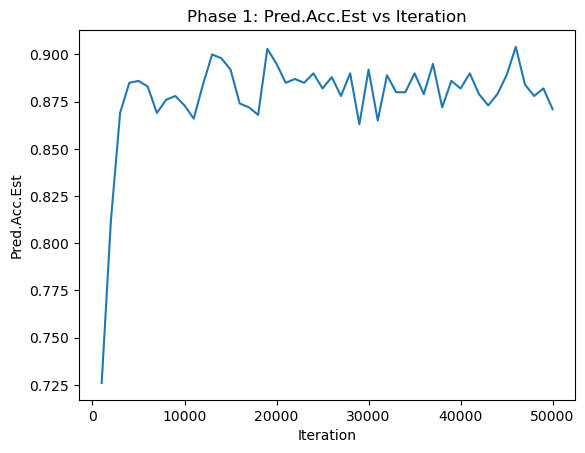

In [15]:
#Plot Windowed Prediction Accuracy Estimates of HEROS Phase 1 Rule Population across learning iterations
plt.plot(tracking_df['Iteration'], tracking_df["Pred.Acc.Est."])
# Add labels and title
plt.xlabel('Iteration')
plt.ylabel("Pred.Acc.Est")
plt.title(f'{"Phase 1: Pred.Acc.Est"} vs Iteration')

# Show plot
plt.show()

### Vizualize Rule Population on Pareto Front Fitness Landscape

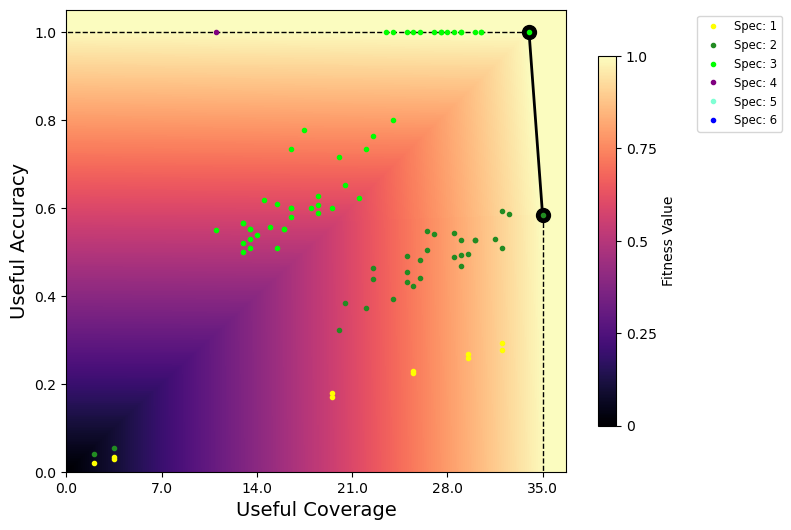

In [16]:
if full_run:
    resolution = 500
    plot_rules = True
    color_rules = True
    heros.get_rule_pareto_landscape(resolution, heros.rule_population, plot_rules, color_rules,show=True,save=True,output_path=output_path)
    #heros.rule_pareto.plot_pareto_landscape(resolution, heros.rule_population, plot_rules, color_rules,show=True,save=True,output_path=folder_path,data_name=output_name)

### Vizualize Rule Population (Feature Specification) as a Rule-Clustered Heatmap (With Optional Rule-Weighting)
Parameters:
* *feature_names*: a list of feature names for the entire training dataset (given in original dataset order)
*  *weighting*: indicates what (if any) weighting is applied to individual rules for the plot ('useful_accuracy', 'fitness', None)
*  *specified_filter*: the number of times a given feature must be specified in rules of the population to be included in the plot (must be a positive integer or None)
*  *display_micro*: controls whether or not additional copies of rules (based on rule numerosity) should be included in the heatmap (True or False) 
*  *show*: indicates whether or not to show the plot (True or False)
*  *save*: indicates whether or not to save the plot to a specified path/filename (True or False)
*  *output_path*: a valid folder path within which to save the plot (str of folder path)
*  *data_name*: a unique name precursor to give to the plot (str)

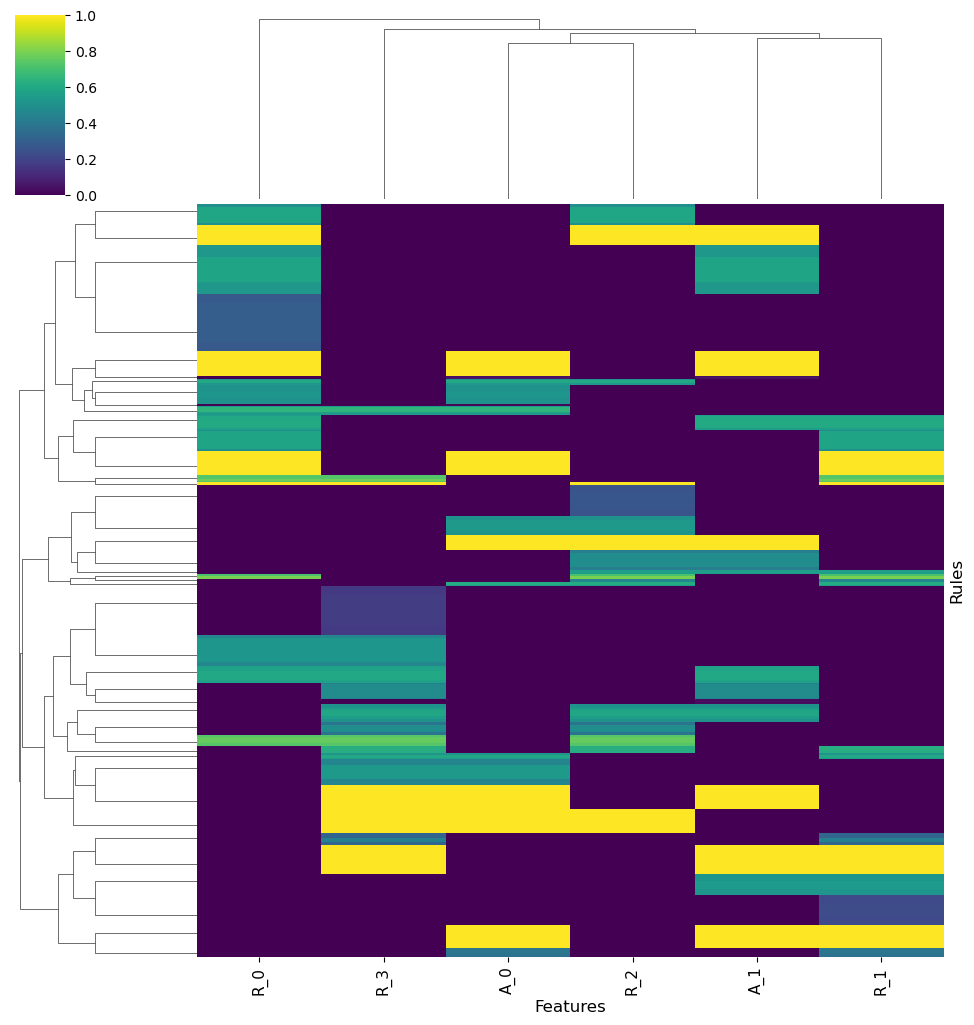

In [17]:
if full_run:
    heros.get_rule_pop_heatmap(feature_names, weighting='useful_accuracy', specified_filter=None, display_micro=True, show=True, save=True, output_path=output_path)

### Vizualize Rule Population (Feature Specification) as a Network (With Optional Rule-Weighting)

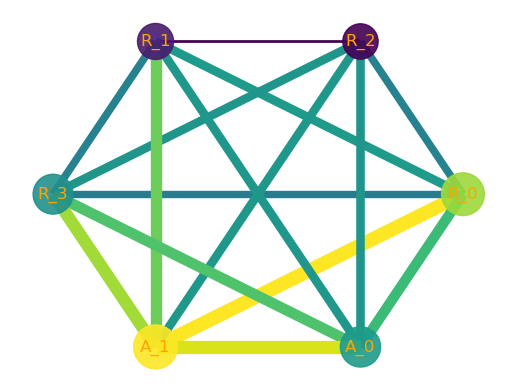

In [18]:
if full_run:
    node_size = 1000
    edge_size = 10
    weighting = 'useful_accuracy'# 'useful_accuracy', 'fitness', None
    display_micro = True
    heros.get_rule_pop_network(feature_names, weighting=weighting, display_micro=display_micro, node_size=node_size, edge_size=edge_size, show=True, save=True, output_path=output_path)
    #heros.rule_population.plot_rule_pop_network(feature_names, weighting=weighting, display_micro=display_micro, node_size=node_size, edge_size=edge_size, show=True, save=True, output_path=folder_path)

***
## HEROS Feature Tracking Scores (Rule Population)
### Get DataFrame and save to .csv

In [19]:
if heros.feat_track != None:
    ft_df = heros.get_ft(feature_names)
    ft_df.shape
    ft_df.to_csv(output_path+'/feature_tracking_scores.csv', index=False)

### Generate Clustered Heatmap of Feature Tracking Scores
Simple first visualization that does not show instance indexes.

In [20]:
if heros.feat_track != None and full_run:
    heros.get_clustered_ft_heatmap(feature_names, show=True, save=True, output_path=output_path)

***
## Prediction (With Rule Population)
### Predict Outcomes and Evaluate With Classification Report

In [21]:
#Prepare Testing Data
try:
    X_test = test_df.drop(excluded_column, axis=1)
except:
    X_test = test_df
try:
    X_test = X_test.drop(instanceID_label, axis=1)
except:
    pass

X_test = X_test.drop(outcome_label, axis=1)

#Finalize separate array-like objects for X and y
X_test = X_test.values
y_test = test_df[outcome_label].values #outcome values

In [22]:
predictions = heros.predict(X_test,whole_rule_pop=True)
print(classification_report(predictions, y_test, digits=8))

              precision    recall  f1-score   support

           0  0.84000000 0.80769231 0.82352941        26
           1  0.80000000 0.83333333 0.81632653        24

    accuracy                      0.82000000        50
   macro avg  0.82000000 0.82051282 0.81992797        50
weighted avg  0.82080000 0.82000000 0.82007203        50



### Get Prediction Probabilities

In [23]:
predictions = heros.predict_proba(X_test,whole_rule_pop=True)
print(predictions)

[{0: 0.7120448376449976, 1: 0.28795516235500246}
 {0: 0.5496688082746479, 1: 0.45033119172535213}
 {0: 0.2531833378077974, 1: 0.7468166621922026}
 {0: 0.6779694842488675, 1: 0.3220305157511325}
 {0: 0.35867508564225337, 1: 0.6413249143577466}
 {0: 0.35587616189794247, 1: 0.6441238381020576}
 {0: 0.4689639845356147, 1: 0.5310360154643854}
 {0: 0.5196569067296892, 1: 0.48034309327031066}
 {0: 0.26189874961208154, 1: 0.7381012503879186}
 {0: 0.422530693616404, 1: 0.5774693063835958}
 {0: 0.541263582975029, 1: 0.458736417024971}
 {0: 0.49613477364687836, 1: 0.5038652263531217}
 {0: 0.7120448376449976, 1: 0.28795516235500246}
 {0: 0.541263582975029, 1: 0.458736417024971}
 {0: 0.7600977912547463, 1: 0.2399022087452538}
 {0: 0.2531833378077974, 1: 0.7468166621922026}
 {0: 0.5700659483561673, 1: 0.4299340516438327}
 {0: 0.6203811663913993, 1: 0.37961883360860066}
 {0: 0.40785864873151123, 1: 0.5921413512684888}
 {0: 0.3611140817115997, 1: 0.6388859182884001}
 {0: 0.2828294355058065, 1: 0.71717

### Evaluation of Archived Rule Populations
To facilitate comparing algorithm performance at earlier learning iterations.

In [24]:
iteration_list = [500,1000,5000,10000]
for iterations in iteration_list:
    print(iterations)
    predictions = heros.predict(X_test,whole_rule_pop=True,rule_pop_iter=iterations)
    print(classification_report(predictions, y_test, digits=8))
    #print runtime to train to this iteration
    print(heros.timer.rule_time_archive[iterations])

500
              precision    recall  f1-score   support

           0  0.76000000 0.73076923 0.74509804        26
           1  0.72000000 0.75000000 0.73469388        24

    accuracy                      0.74000000        50
   macro avg  0.74000000 0.74038462 0.73989596        50
weighted avg  0.74080000 0.74000000 0.74010404        50

0.24718117713928223
1000
              precision    recall  f1-score   support

           0  0.80000000 0.74074074 0.76923077        27
           1  0.72000000 0.78260870 0.75000000        23

    accuracy                      0.76000000        50
   macro avg  0.76000000 0.76167472 0.75961538        50
weighted avg  0.76320000 0.76000000 0.76038462        50

0.5322136878967285
5000
              precision    recall  f1-score   support

           0  0.92000000 0.82142857 0.86792453        28
           1  0.80000000 0.90909091 0.85106383        22

    accuracy                      0.86000000        50
   macro avg  0.86000000 0.86525974 0.8594

***
## HEROS Trained Model Population (Phase 2: Rule-sets)
### Get DataFrame and save to .csv

In [25]:
model_pop_df = heros.get_model_pop()
model_pop_df.to_csv(output_path+'/model_pop.csv', index=False)

### Vizualize Model Population on Pareto Front Fitness Landscape

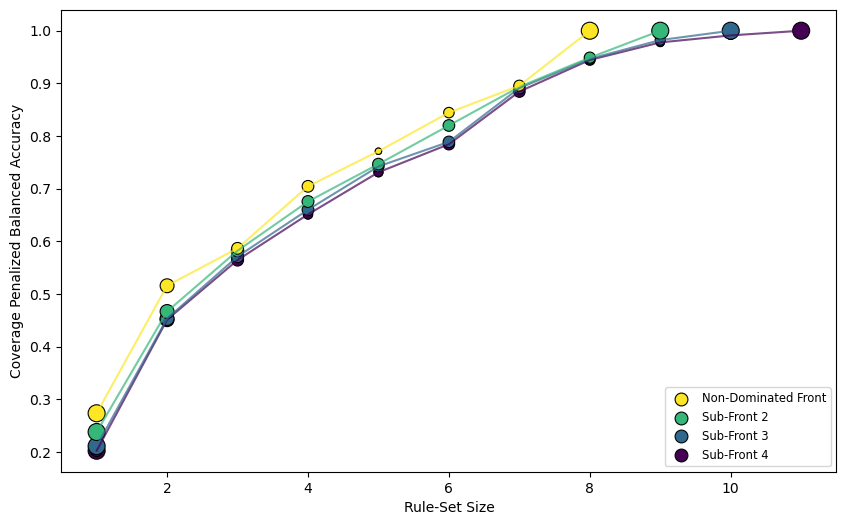

In [26]:
if full_run:
    resolution = 500
    plot_models = True
    heros.get_model_pareto_fronts(show=True,save=True,output_path=output_path)
    #heros.get_model_pareto_landscape(resolution, heros.model_population, plot_models, show=True,save=True,output_path=output_path)

***
## HEROS Top Model Identification and Inspection
### Select and Report Top Model (Ranked by Accuracy, Coverage, then Rule Count)

In [27]:
set_df = heros.get_model_rules() #returns top training model by default based on balanced accuracy, then covering, then rule-set size.
set_df.to_csv(output_path+'/top_default_model_rules.csv', index=False)
print(set_df)

  Condition Indexes Condition Values  Action  Numerosity   Fitness  \
0         [0, 1, 4]        [1, 0, 1]       1           6  0.997857   
1         [0, 1, 3]        [0, 1, 1]       1           6  0.998143   
2         [0, 1, 2]        [0, 0, 1]       1          10  0.998714   
3         [0, 1, 5]        [1, 1, 0]       0           9  0.996857   
4         [0, 1, 5]        [1, 1, 1]       1           7  0.997429   
5         [0, 1, 4]        [1, 0, 0]       0           4  0.997857   
6         [0, 1, 2]        [0, 0, 0]       0           6  1.000000   
7         [0, 1, 3]        [0, 1, 0]       0           9  0.997714   

   Useful Accuracy  Useful Coverage  Accuracy  Match Cover  Correct Cover  \
0              1.0             27.5       1.0           55             55   
1              1.0             28.5       1.0           57             57   
2              1.0             30.5       1.0           61             61   
3              1.0             24.0       1.0           48   

### Select and Report Indexed Model

In [28]:
model_index = 1
set_df = heros.get_model_rules(model_index)
print(set_df)

  Condition Indexes Condition Values  Action  Numerosity   Fitness  \
0         [0, 1, 2]        [0, 0, 0]       0           6  1.000000   
1         [0, 1, 3]        [0, 1, 0]       0           9  0.997714   
2         [0, 1, 4]        [1, 0, 0]       0           4  0.997857   
3         [0, 1, 4]        [1, 0, 1]       1           6  0.997857   
4         [0, 1, 5]        [1, 1, 1]       1           7  0.997429   
5         [0, 1, 2]        [0, 0, 1]       1          10  0.998714   
6         [0, 1, 5]        [1, 1, 0]       0           9  0.996857   
7         [0, 1, 3]        [0, 1, 1]       1           6  0.998143   
8         [0, 4, 5]        [1, 1, 1]       1           9  0.997286   

   Useful Accuracy  Useful Coverage  Accuracy  Match Cover  Correct Cover  \
0              1.0             34.0       1.0           68             68   
1              1.0             27.0       1.0           54             54   
2              1.0             27.5       1.0           55          

***
## Prediction (With Top Model)
### Predict Outcomes and Evaluate With Classification Report

In [29]:
predictions = heros.predict(X_test)
print(classification_report(predictions, y_test, digits=8))

              precision    recall  f1-score   support

           0  1.00000000 1.00000000 1.00000000        25
           1  1.00000000 1.00000000 1.00000000        25

    accuracy                      1.00000000        50
   macro avg  1.00000000 1.00000000 1.00000000        50
weighted avg  1.00000000 1.00000000 1.00000000        50



### Get Prediction Probabilities

In [30]:
predictions = heros.predict_proba(X_test)
print(predictions)

[{0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0}
 {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0}
 {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}]


### Get Coverage of Instances

In [31]:
predictions = heros.predict_covered(X_test)
print(predictions)
print(str(sum(predictions))+' instances covered out of '+str(len(predictions)))


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
50 instances covered out of 50


### Evaluation of Archived Model Populations (Top Training Model)
To facilitate comparing algorithm performance at earlier learning iterations.

In [32]:
model_iteration_list = [10,50,100]
for iterations in model_iteration_list:
    print(iterations)
    predictions = heros.predict(X_test,whole_rule_pop=False,model_pop_iter=iterations)
    print(classification_report(predictions, y_test, digits=8))

10
              precision    recall  f1-score   support

           0  1.00000000 1.00000000 1.00000000        25
           1  1.00000000 1.00000000 1.00000000        25

    accuracy                      1.00000000        50
   macro avg  1.00000000 1.00000000 1.00000000        50
weighted avg  1.00000000 1.00000000 1.00000000        50

50
              precision    recall  f1-score   support

           0  1.00000000 1.00000000 1.00000000        25
           1  1.00000000 1.00000000 1.00000000        25

    accuracy                      1.00000000        50
   macro avg  1.00000000 1.00000000 1.00000000        50
weighted avg  1.00000000 1.00000000 1.00000000        50

100
              precision    recall  f1-score   support

           0  1.00000000 1.00000000 1.00000000        25
           1  1.00000000 1.00000000 1.00000000        25

    accuracy                      1.00000000        50
   macro avg  1.00000000 1.00000000 1.00000000        50
weighted avg  1.00000000 1.0

## Model Performance Tracking

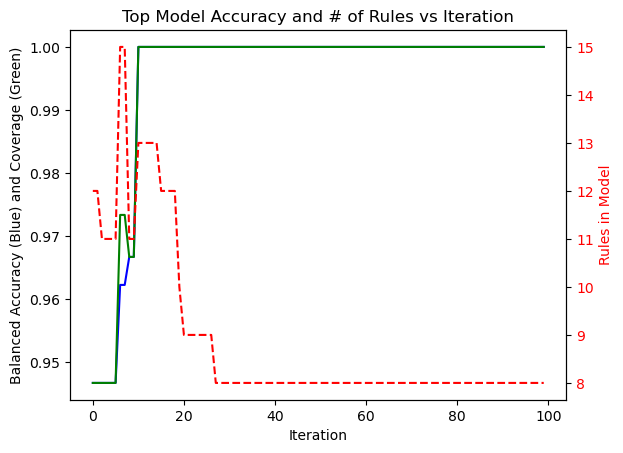

In [33]:
top_models = heros.export_model_growth()
top_models.to_csv(output_path+'/model_tracking.csv', index=False)

# Create the plot
fig, ax1 = plt.subplots()
# Plot the first line on the left y-axis
ax1.plot(top_models.index, top_models["Accuracy"], 'b-', label='Model Balanced Accuracy')  # 'b-' specifies a blue solid line
ax1.plot(top_models.index, top_models["Coverage"], 'g-', label='Model Coverage')  # 'b-' specifies a blue solid line

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Balanced Accuracy (Blue) and Coverage (Green)')
ax1.tick_params(axis='y')
# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(top_models.index, top_models["Number of Rules"], 'r--', label='Rules in Model')  # 'r--' specifies a red dashed line
ax2.set_ylabel('Rules in Model', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title(f'{"Top Model Accuracy and # of Rules"} vs Iteration')
plt.savefig(output_path+'/model_tracking_line_graph.png', bbox_inches="tight")
# Show plot
plt.show()

## Using Testing Accuracy to Pick a Top Model from the Model Pareto Front
### Using the final model population

In [34]:
#Identify model indexes of all models on front
model_on_front_indexes = []
model_on_front_rule_count = []
# Loop through each row
for index, row in model_pop_df.iterrows():
    if row['Model on Front'] == 1:
        model_on_front_indexes.append(index)
        model_on_front_rule_count.append(row['Number of Rules'])
print(str(len(model_on_front_indexes))+' models on front.')
#print(model_on_front_indexes)
#For each one run prediction to get prediction accuracy and instance coverage on testing data
model_test_accuracies = []
model_test_coverages = []
model_rule_counts = []
for index in model_on_front_indexes:
    #Handle class prediction and accuracy
    predictions = heros.predict(X_test,whole_rule_pop=False, target_model=index)
    balanced_acc = balanced_accuracy_score(y_test, predictions)
    model_test_accuracies.append(balanced_acc)
    #Handle model coverage
    coverages = heros.predict_covered(X_test,whole_rule_pop=False, target_model=index)
    coverage = sum(coverages)/len(coverages) #proportion of instances covered
    model_test_coverages.append(coverage)
    model_rule_counts.append(len(heros.model_population.pop_set[index].rule_IDs))

print('Model testing accuracies: '+str(model_test_accuracies))
print('Model testing coverages: '+str(model_test_coverages))
print('Model rule counts: '+str(model_rule_counts))

#Identify the model index with the highest prediction accuracy
best_accuracy = 0
best_coverage = 0
best_rule_count = np.inf
best_model_index = 0
for i in range(0,len(model_on_front_indexes)):
    if (model_test_accuracies[i] > best_accuracy and model_test_coverages[i] >= best_coverage) or (model_test_accuracies[i] >= best_accuracy and model_test_coverages[i] >= best_coverage and model_on_front_rule_count[i] < best_rule_count):
        best_accuracy = model_test_accuracies[i]
        best_coverage = model_test_coverages[i]
        best_rule_count = model_on_front_rule_count[i]
        best_model_index = model_on_front_indexes[i]

print('Best model testing accuracy: '+str(best_accuracy))
print('Best model testing coverage: '+str(best_coverage))    
print('Best rule count: '+str(best_rule_count))
print('Best model index: '+str(best_model_index))

model_index = best_model_index
set_df = heros.get_model_rules(model_index)
print(set_df)

#Report results for the new top model as well as it's model details and save output
set_df = heros.get_model_rules(best_model_index)
set_df.to_csv(output_path+'/top_testing_model_rules.csv', index=False)

predictions = heros.predict(X_test,whole_rule_pop=False, target_model=best_model_index)
print(classification_report(predictions, y_test, digits=8))

9 models on front.
Model testing accuracies: [1.0, 0.94, 0.9199999999999999, 0.76, 0.76, 0.72, 0.64, 0.52, 0.54]
Model testing coverages: [1.0, 0.94, 0.86, 1.0, 1.0, 0.94, 0.86, 1.0, 0.54]
Model rule counts: [8, 7, 6, 5, 5, 4, 3, 2, 1]
Best model testing accuracy: 1.0
Best model testing coverage: 1.0
Best rule count: 8
Best model index: 0
  Condition Indexes Condition Values  Action  Numerosity   Fitness  \
0         [0, 1, 4]        [1, 0, 1]       1           6  0.997857   
1         [0, 1, 3]        [0, 1, 1]       1           6  0.998143   
2         [0, 1, 2]        [0, 0, 1]       1          10  0.998714   
3         [0, 1, 5]        [1, 1, 0]       0           9  0.996857   
4         [0, 1, 5]        [1, 1, 1]       1           7  0.997429   
5         [0, 1, 4]        [1, 0, 0]       0           4  0.997857   
6         [0, 1, 2]        [0, 0, 0]       0           6  1.000000   
7         [0, 1, 3]        [0, 1, 0]       0           9  0.997714   

   Useful Accuracy  Useful C

In [35]:
predictions = heros.predict_proba(X_test,whole_rule_pop=False, target_model=best_model_index)
print(predictions)



[{0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0}
 {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0}
 {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0}
 {0: 1.0, 1: 0.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0} {0: 1.0, 1: 0.0} {0: 1.0, 1: 0.0}
 {0: 0.0, 1: 1.0} {0: 0.0, 1: 1.0}]


In [36]:
predictions = heros.predict_covered(X_test,whole_rule_pop=False, target_model=best_model_index)
print(predictions)
print(str(sum(predictions))+' instances covered out of '+str(len(predictions)))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
50 instances covered out of 50


### Evaluation of Archived Model Populations (Picking Top model from Front using Testing data)
To facilitate comparing algorithm performance at earlier learning iterations.

In [37]:
model_iteration_list = [10,50,100]
for iterations in model_iteration_list:
    print(iterations)
    #Identify model indexes of all models on front
    model_on_front_indexes = []
    model_on_front_rule_count = []
    # Loop through each row
    for index, row in model_pop_df.iterrows():
        if row['Model on Front'] == 1:
            model_on_front_indexes.append(index)
            model_on_front_rule_count.append(row['Number of Rules'])
    #For each one run prediction to get prediction accuracy and instance coverage on testing data
    model_accuracies = []
    model_coverages = []
    for index in model_on_front_indexes:
        #Handle class prediction and accuracy
        predictions = heros.predict(X_test,whole_rule_pop=False, target_model=index,model_pop_iter=iterations)
        balanced_acc = balanced_accuracy_score(y_test, predictions)
        model_accuracies.append(balanced_acc)
        #Handle model coverage
        coverages = heros.predict_covered(X_test,whole_rule_pop=False, target_model=index,model_pop_iter=iterations)
        coverage = sum(coverages)/len(coverages) #proportion of instances covered
        model_coverages.append(coverage)
    #Identify the model index with the highest prediction accuracy
    best_accuracy = 0
    best_coverage = 0
    best_rule_count = np.inf
    best_model_index = 0
    for i in range(0,len(model_on_front_indexes)):
        if (model_accuracies[i] > best_accuracy and model_coverages[i] >= best_coverage) or (model_accuracies[i] == best_accuracy and model_coverages[i] >= best_coverage and model_on_front_rule_count[i] < best_rule_count):
            best_accuracy = model_accuracies[i]
            best_coverage = model_coverages[i]
            best_rule_count = model_on_front_rule_count[i]
            best_model_index = model_on_front_indexes[i]
    print('Best model testing accuracy: '+str(best_accuracy))
    print('Best model coverage: '+str(best_coverage))
    print('Best rule count: '+str(best_rule_count))
    print('Best model index: '+str(best_model_index))

10
Best model testing accuracy: 1.0
Best model coverage: 1.0
Best rule count: 8
Best model index: 0
50
Best model testing accuracy: 1.0
Best model coverage: 1.0
Best rule count: 8
Best model index: 0
100
Best model testing accuracy: 1.0
Best model coverage: 1.0
Best rule count: 8
Best model index: 0


***
## Get Runtime Summary

In [38]:
time_df = heros.get_runtimes()
time_df.to_csv(output_path+'/runtimes.csv', index=False)
print(time_df)

      Global    Phase 1    Phase 2  Rule Initialization  Rule Covering  \
0  73.870153  30.817191  43.052962                0.003       0.013018   

   Rule Equality  Rule Matching  Rule Evaluation  Feature Tracking  \
0       0.778444       2.730905        32.897945               0.0   

   Rule Subsumption  Rule Selection  Rule Mating  Rule Deletion  \
0          0.449869        1.059759     5.013273       2.484742   

   Rule Compaction  Rule Prediction  
0         0.005507         0.977002  
